In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn as nn

from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from torchvision import models
from tqdm.notebook import tqdm, trange

%matplotlib inline

In [2]:
BATCH_SIZE = 56

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


# !cp -R '/content/drive/MyDrive/Trees' './'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
BASE_PATH = "./Trees/RGBReNirH"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
TABLE_PATH = os.path.join(BASE_PATH, "data.csv")
TYPES_PATH = os.path.join(BASE_PATH, "types.csv")

In [6]:
TARGET_COLUMN = "latin"

In [7]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path=IMAGES_PATH, table_path=TABLE_PATH, types_path=TYPES_PATH, target_column=TARGET_COLUMN):
        super().__init__()
        
        self.types = pd.read_csv(types_path, index_col=0)
        self.table = pd.read_csv(table_path, index_col=0, 
                                 converters={"latin": lambda x: self.types.loc[x].type if x != "NA" else np.nan}).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        self.target_column = target_column
        
        self.max_h, self.max_w = 0, 0
        self.depth_max = 0
        self.re_max = 0
        self.nir_max = 0
        images = []
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tif")
            img_rgbdrenir = skimage.io.imread(file_path)[:, :, [0, 1, 2, 5, 3, 4]].clip(0).transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbdrenir.shape[2])
            self.max_w = max(self.max_w, img_rgbdrenir.shape[3])
            self.depth_max = max(self.depth_max, img_rgbdrenir[:, 3, :, :].max())
            self.re_max = max(self.re_max, img_rgbdrenir[:, 4, :, :].max())
            self.nir_max = max(self.nir_max, img_rgbdrenir[:, 5, :, :].max())
            images.append(img_rgbdrenir)
        
        self.channel_mean, self.channel_std = 0, 0
        padded_images = []
        for image in images:
            image[:, :3, :, :] /= 255.
            image[:, 3, :, :] /= self.depth_max
            image[:, 4, :, :] /= self.re_max
            image[:, 5, :, :] /= self.nir_max
            self.channel_mean += image.mean(axis=(0, 2, 3))
            self.channel_std += image.std(axis=(0, 2, 3))

            img_h, img_w = image.shape[2:]
            h_pos = (self.max_h - img_h) // 2
            w_pos = (self.max_w - img_w) // 2
            padded = np.zeros((1, 6, self.max_h, self.max_w))
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)            
            
        self.images = torch.tensor(np.concatenate(padded_images), dtype=torch.float)
        if self.target_column == "latin":
            self.labels = torch.tensor(self.table[self.target_column].values, dtype=torch.long)
        else:
            self.labels = torch.tensor(self.table[self.target_column].values, dtype=torch.float)
        self.channel_mean /= len(self.images)
        self.channel_std /= len(self.images)
        
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.table)

In [8]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x, y

    def __len__(self):
        return len(self.subset)

In [9]:
data = TreeDataset()

In [10]:
train_idx, test_idx = train_test_split(np.arange(len(data)), 
                                       test_size=0.2, 
                                       random_state=39, 
                                       shuffle=True, 
                                       stratify=data.labels)

val_idx, test_idx = train_test_split(test_idx, 
                                     test_size=0.5, 
                                     random_state=39, 
                                     shuffle=True, 
                                     stratify=data[test_idx][1])

In [11]:
train_subset = Subset(data, train_idx)
val_subset = Subset(data, val_idx)
test_subset = Subset(data, test_idx)

In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:
all_transform = tr.Compose([
    #tr.Normalize(data.channel_mean, data.channel_std),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    tr.RandomRotation(degrees=180),
    tr.CenterCrop((256, 256)),
    #tr.RandomApply([AddGaussianNoise(),]),
])
rgb_transform = tr.Compose([
    #tr.RandomAutocontrast(),
    #tr.RandomAdjustSharpness(0.5),
])

prepare_transform = tr.Compose([
    #tr.Normalize(data.channel_mean, data.channel_std),
])

In [14]:
train_dataset = TreeDatasetFromSubset(train_subset, all_transform=all_transform, rgb_transform=rgb_transform)
val_dataset = TreeDatasetFromSubset(val_subset, all_transform=prepare_transform)
test_dataset = TreeDatasetFromSubset(test_subset, all_transform=prepare_transform)

Targets:
tensor(0)


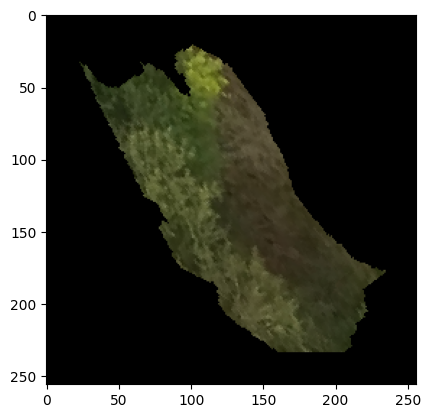

In [15]:
print("Targets:")
idx = np.random.randint(0, 100)
print(train_dataset[idx][1])
plt.imshow(train_dataset[idx][0][:3, :, :].movedim(0, -1))
plt.show()

In [16]:
def make_weights_for_balanced_classes(data, indices=None):
    n_images = len(data)
    count_per_class = np.bincount(data.table.latin, minlength=len(data.table.latin.unique()))
    weight_per_class = (float(n_images) / count_per_class)
    weights = weight_per_class[data.table.latin]
    if indices is not None:
        weights = weights[indices]
    return torch.tensor(weights)

In [17]:
train_weights = make_weights_for_balanced_classes(train_subset.dataset, train_subset.indices)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    drop_last=False,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [18]:
class Net(nn.Module):
    def __init__(self, classes_num, pretrained=models.efficientnet_b0, dropout=0.3, remaining_layers=3):
        super().__init__()

        # self.feature_extractor = pretrained(weights="DEFAULT")
        # first_layer = self.feature_extractor.features[0][0]
        # self.feature_extractor.features[0][0] = nn.Conv2d(first_layer.in_channels + remaining_layers,
        #                                                   first_layer.out_channels,
        #                                                   first_layer.kernel_size,
        #                                                   first_layer.stride,
        #                                                   first_layer.padding,
        #                                                   bias=first_layer.bias)
        
        # embed_size = self.feature_extractor.classifier[1].in_features
        # self.feature_extractor.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(embed_size, embed_size),
        #     nn.BatchNorm1d(embed_size),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(embed_size, embed_size),
        #     nn.BatchNorm1d(embed_size),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(embed_size, classes_num),
        #     nn.LogSoftmax(dim=1),
        # )


        self.rgb_extractor = pretrained(weights="DEFAULT")
        self.rest_extractor = pretrained()

        rgb_embed_size = self.rgb_extractor.classifier[1].in_features
        rest_embed_size = self.rest_extractor.classifier[1].in_features

        self.rgb_extractor.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(rgb_embed_size, rgb_embed_size),
            nn.BatchNorm1d(rgb_embed_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(rgb_embed_size, rgb_embed_size),
            nn.BatchNorm1d(rgb_embed_size),
            nn.SiLU(),
            nn.Dropout(dropout),
        )

        self.rest_extractor.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(rest_embed_size, rest_embed_size),
            nn.BatchNorm1d(rest_embed_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(rest_embed_size, rest_embed_size),
            nn.BatchNorm1d(rest_embed_size),
            nn.SiLU(),
            nn.Dropout(dropout),
        )
        
        final_embed_size = rgb_embed_size + rest_embed_size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(final_embed_size, final_embed_size),
            nn.BatchNorm1d(final_embed_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(final_embed_size, classes_num),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        # return self.feature_extractor(x)
        rgb = x[:, :3, :, :]
        rest = x[:, 3:, :, :]

        rgb_embed = self.rgb_extractor(rgb)
        rest_embed = self.rest_extractor(rest)

        final_embed = torch.cat((rgb_embed, rest_embed), dim=1)
        output = self.classifier(final_embed)
        return output

In [19]:
import IPython


def train_loop(model, dataloader, loss_clf_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_acc = []
    train_loss = []
    percentage = 0
    
    for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred_clf = model(X)
        loss = loss_clf_fn(pred_clf, y_clf)
        train_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (num_batches - 1) >= percentage:
            percentage = int(batch / (num_batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Batch NLL Loss: {loss.item():>8f}')
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}


def test_loop(model, dataloader,  loss_clf_fn, history_loss=None, history_acc=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    val_acc = []
    val_loss = []
    correct = 0

    with torch.no_grad():
        for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_clf = y_clf.to(device)
            pred_clf = model(X)
            loss = loss_clf_fn(pred_clf, y_clf)
            val_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
            val_loss.append(loss.item())
            correct += (pred_clf.argmax(1) == y_clf).type(torch.float).sum().item()

        correct /= size
        total_loss = np.mean(val_loss)
        print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation NLL Loss: {total_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(total_loss)
    if history_acc is not None:
        history_acc.append(correct)
    
    return {'val_loss': total_loss, 'val_acc': correct}

In [20]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

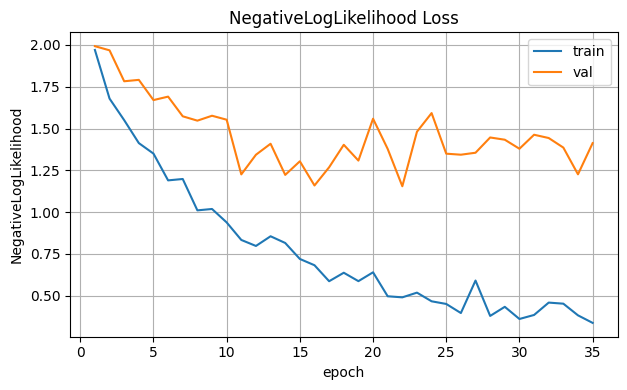

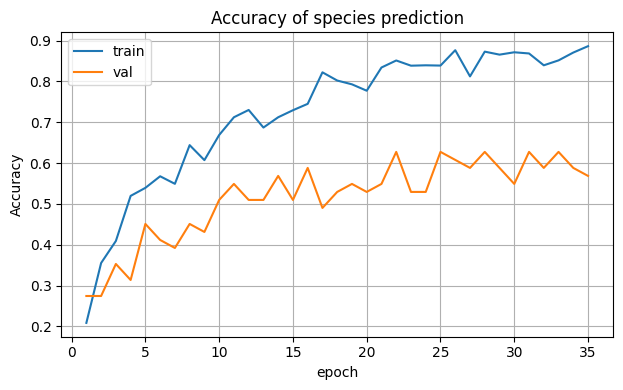

Epoch 36
-------------------------------


'[0/409] Batch NLL Loss: 0.322278'

Batch #:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [21]:
loss_clf = nn.NLLLoss()


epochs = 100

models_results = {}
net = Net(classes_num=len(data.label_map)).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-7)

train_acc, train_loss = [], []
val_acc, val_loss = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    print("-------------------------------")
    train_loop(net, train_dataloader, loss_clf, optimizer, history_loss=train_loss, history_acc=train_acc)
    test_loop(net, val_dataloader, loss_clf, history_loss=val_loss, history_acc=val_acc)
    scheduler.step(val_loss[-1])
    IPython.display.clear_output()
    plot_learning_process(train_loss, val_loss, "NegativeLogLikelihood Loss")
    plot_learning_process(train_acc, val_acc, "Accuracy of species prediction")

In [ ]:
models_results[f"train_{TARGET_COLUMN}_acc"] = train_acc
models_results[f"train_{TARGET_COLUMN}_loss"] = train_loss
models_results[f"val_{TARGET_COLUMN}_acc"] = val_acc
models_results[f"val_{TARGET_COLUMN}_loss"] = val_loss

In [ ]:
results_df = pd.DataFrame(models_results)

In [ ]:
results_df.index.name = "Epoch"
results_df.index = results_df.index + 1
results_df.dropna()

In [ ]:
plot_learning_process(results_df.train_latin_loss, results_df.val_latin_loss, "NegativeLogLikelihood Loss")
plot_learning_process(results_df.train_latin_acc, results_df.val_latin_acc, "Accuracy of species prediction")

In [ ]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [ ]:
PATH = f"{TARGET_COLUMN}_prediction_model.pt"
assert not os.path.exists(PATH), "There is a checkpoint already! Remove this assert to override"
test_results = test_loop(net, test_dataloader, loss_clf)
torch.save({
    'epoch': epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_results["val_loss"],
    'acc': test_results["val_acc"]
},
    PATH)

In [ ]:
# model = RGBDNet(classes_num=len(data.label_map)).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# acc = checkpoint['acc']

# model.eval()

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
preds = []
trues = []
with torch.no_grad():
    for X, y_clf in tqdm(val_dataloader, leave=False, desc="Batch #"):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred = net(X).argmax(1)
        preds.extend(pred.tolist())
        trues.extend(y_clf.tolist())

Batch #:   0%|          | 0/1 [00:00<?, ?it/s]

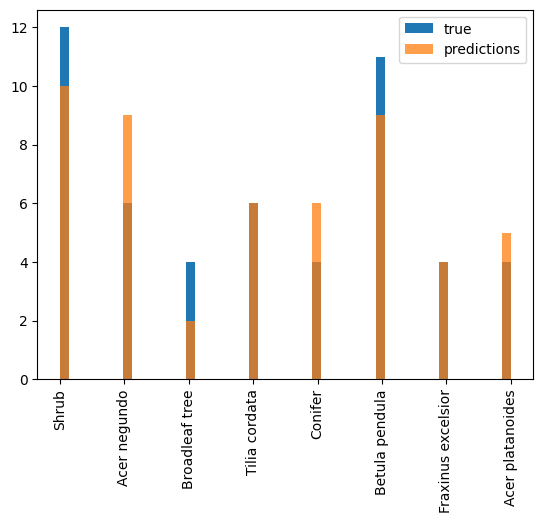

In [24]:
plt.hist(trues, bins=50, label="true")
plt.hist(preds, bins=50, label="predictions", alpha=0.75)
plt.xticks(ticks=range(len(data.label_map)), labels=list(data.label_map.keys()), rotation=90)
plt.legend()
plt.show()

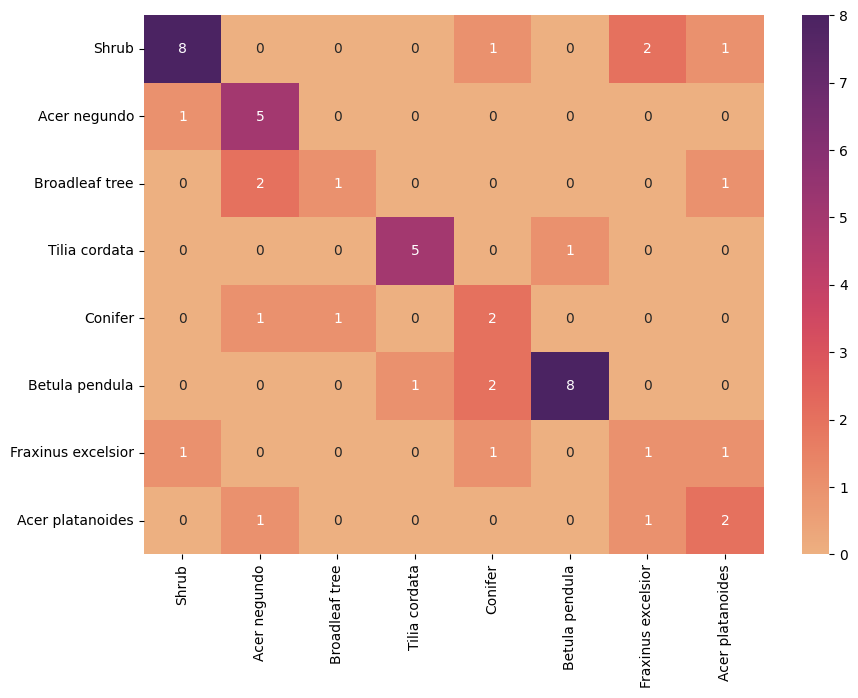

In [25]:
df_cm = pd.DataFrame(confusion_matrix(trues, preds), index=data.label_map.keys(), columns=data.label_map.keys())
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, cmap="flare", annot=True)
plt.show()

In [ ]:
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc
#!jupyter nbconvert --to pdf /content/ResNetClf.ipynb